In [ ]:
# Execute iff running in Colab
!pip install torchinfo
!pip install lightning
!pip install torchmetrics
home_folder = '/content/drive/My Drive/Colab Notebooks/kenyan-food-classification/'
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torchinfo
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2 as T
from torchvision import models
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy
from typing import Dict
from dataclasses import dataclass
from pathlib import Path

In [2]:
# run iff executing locally
home_folder = ''

In [3]:
@dataclass(frozen=True)
class DataConfiguration:
    data_folder = home_folder + 'data/'
    images_folder = data_folder + 'images/'
    num_workers: int = 2
    batch_size: int = 32
    num_classes = 13

@dataclass(frozen=True)
class TrainingConfiguration:
    """
    Describes configuration of the training process
    """
    model_name: str = 'resnet50'
    weights: str = "DEFAULT"
    max_epochs: int = 10
    learning_rate: float = 4e-4  # initial learning rate for lr scheduler
    fine_tune_start: int = 4
    precision: str = "32"

data_config = DataConfiguration()
train_config = TrainingConfiguration()

def build_class_to_idx(class_labels) -> Dict[str, int]:
    unique_classes = sorted(set(class_labels))
    return {cls: idx for idx, cls in enumerate(unique_classes)}

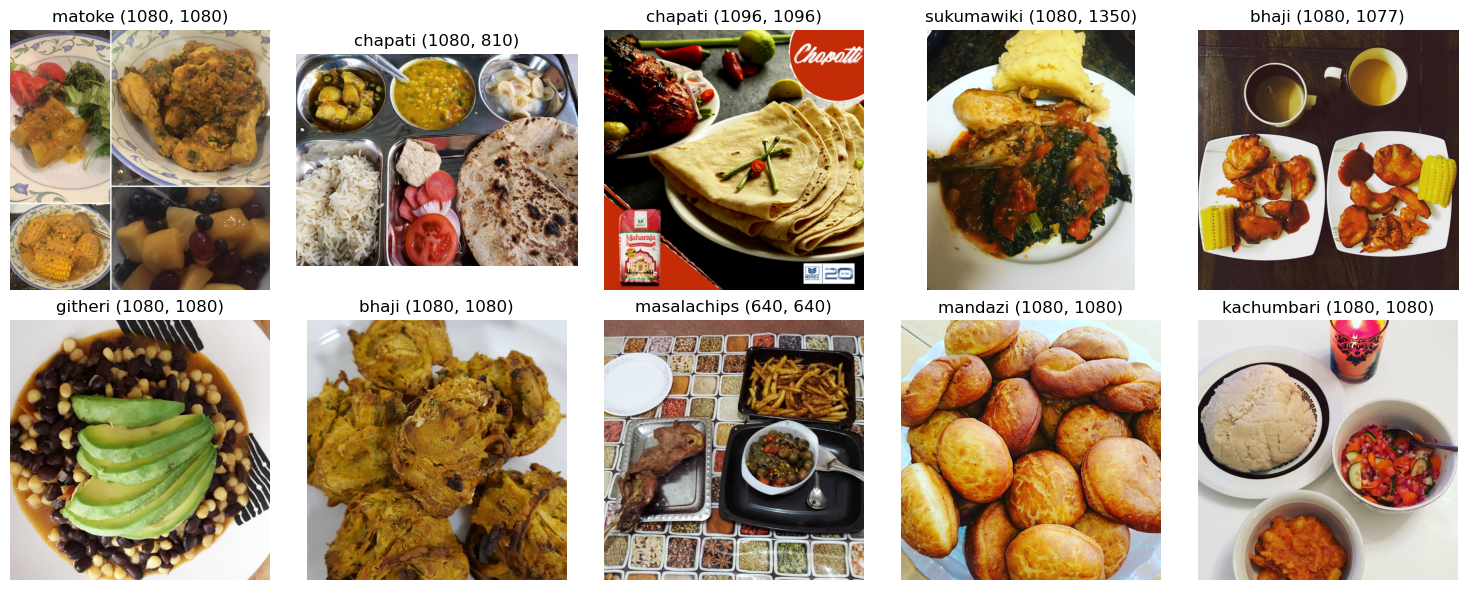

In [5]:
# show random images from the dataset to illustrate the classification problem
if 'train_csv' not in locals():
    train_csv = pd.read_csv(data_config.data_folder + 'train.csv')
plt.figure(figsize=(15, 6))
for i, row in train_csv.sample(10).reset_index(drop=True).iterrows():
    img_path = f'{data_config.images_folder}{row['id']}.jpg'
    img = Image.open(img_path)
    img_width, img_height = img.size
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'{row['class']} ({img_width}, {img_height})')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
class ClassLabeledImagesDataset(TorchDataset):
    def __init__(
            self,
            x: pd.Series,
            y: pd.Series,
            class_to_idx: Dict[str, int],
            transform: T.Compose,
    ):
        assert len(x) == len(y), "x and y series must be same length"
        self.x = x.reset_index(drop=True)
        self.y = y.reset_index(drop=True).map(class_to_idx)
        self.transform = transform

        self._paths = []
        for id in self.x:
            path = f'{data_config.images_folder}{id}.jpg'
            if not Path(path).exists():
                raise FileNotFoundError(f"Image not found: {path}")
            self._paths.append(path)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx: int):
        return self.transform(Image.open(self._paths[idx]).convert("RGB")), self.y[idx]

In [ ]:
class KenyanFoodsDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, num_workers=8, img_size=224):

        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.num_classes = 13

        imagenet_mean = [0.485, 0.456, 0.406]
        imagenet_std = [0.229, 0.224, 0.225]

        self.preprocess_transforms = T.Compose([
            T.Resize((img_size, img_size), antialias=True),
            T.ToTensor(),
        ])

        self.common_transforms = T.Compose([
            self.preprocess_transforms,
            T.Normalize(imagenet_mean, imagenet_std),
        ])

        self.aug_transforms = T.Compose([
            T.RandomResizedCrop(256),
            T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(90),
            T.RandomGrayscale(p=0.1),
            self.common_transforms,
            T.RandomErasing(),
        ])

    def setup(self, stage=None):
        train = pd.read_csv(train_config.data_folder + 'train.csv')
        x_id = train['id']
        y = train['class']
        x_id_train, x_id_val, y_train, y_val = train_test_split(x_id, y, random_state=42, test_size=0.2, stratify=y)
        class_to_idx = build_class_to_idx(y)
        self.train_ds = ClassLabeledImagesDataset(x_id_train, y_train, class_to_idx, self.aug_transforms)
        self.val_ds = ClassLabeledImagesDataset(x_id_val, y_val, class_to_idx, self.common_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [ ]:
class ResNetFineTuningModule(pl.LightningModule):
    def __init__(
        self,
        num_classes,
        resnet_model_name="resnet50",
        weights="DEFAULT",
        fine_tune_start=4,
        learning_rate=0.01,
    ):
        super().__init__()

        self.save_hyperparameters()

        resnet = getattr(models, self.hparams.resnet_model_name)(weights=self.hparams.weights)

        if self.hparams.weights:
            for param in resnet.parameters():
                param.requires_grad = False

            if self.hparams.fine_tune_start <= 1:
                for param in resnet.layer1.parameters():
                    param.requires_grad = True

            if self.hparams.fine_tune_start <= 2:
                for param in resnet.layer2.parameters():
                    param.requires_grad = True

            if self.hparams.fine_tune_start <= 3:
                for param in resnet.layer3.parameters():
                    param.requires_grad = True

            if self.hparams.fine_tune_start <= 4:
                for param in resnet.layer4.parameters():
                    param.requires_grad = True

        last_layer_in = resnet.fc.in_features
        resnet.fc = nn.Linear(last_layer_in, self.hparams.num_classes)

        self.resnet = resnet

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")

    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, *args, **kwargs):
        data, target = batch
        output = self(data)
        loss = F.cross_entropy(output, target)
        pred_batch = output.detach().argmax(dim=1)
        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_acc(pred_batch, target)

        # Arguments such as on_epoch, on_step and logger are set automatically depending on
        # the hook methods they've been called from
        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=True)

        # logging and adding current batch_acc to progress_bar
        self.log("train/batch_acc", self.mean_train_acc, prog_bar=True, logger=True)
        return loss


    def on_train_epoch_end(self):
        # Calculate epoch level metrics for the train set
        self.log("train/loss", self.mean_train_loss, prog_bar=True, logger=True)
        self.log("train/acc", self.mean_train_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)


    def validation_step(self, batch, *args, **kwargs):
        data, target = batch
        output = self(data)
        loss = F.cross_entropy(output, target)
        pred_batch = output.argmax(dim=1)

        # Update logs
        self.mean_valid_loss(loss, weight=data.shape[0])
        self.mean_valid_acc(pred_batch, target)


    def on_validation_epoch_end(self):
        # Calculate epoch level metrics for the validation set
        self.log("valid/loss", self.mean_valid_loss, prog_bar=True, logger=True)
        self.log("valid/acc", self.mean_valid_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        # example of using scheduler
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        #
        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": scheduler,
        #     "monitor": "val_loss",  # optional for ReduceLROnPlateau
        # }
        return optimizer

In [ ]:
def run_training():
    pl.seed_everything(42, workers=True)

    # init model
    data_module = KenyanFoodsDataModule(
        batch_size=data_config.batch_size, num_workers=data_config.num_workers
    )

    model = ResNetFineTuningModule(
        resnet_model_name=train_config.model_name,
        weights=train_config.weights,
        fine_tune_start=train_config.fine_tune_start,
        num_classes=data_module.num_classes,
        learning_rate=train_config.learning_rate,
    )

    checkpoint_callback = ModelCheckpoint(
        monitor='valid/acc',
        mode="max",
        filename='resnet50-fine-tuning-epoch-{epoch:02d}',
        auto_insert_metric_name=False,
        save_weights_only=True,
    )

    early_stopping_callback = EarlyStopping(monitor="valid/loss", patience=20)

    # most basic trainer, uses good defaults
    trainer = pl.Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        max_epochs=train_config.max_epochs,
        precision = train_config.precision,
        callbacks=[
            early_stopping_callback,
            checkpoint_callback,
        ]
    )

    trainer.fit(model, data_module)

    return model, data_module, checkpoint_callback

In [ ]:
model, data_module, checkpoint_callback = run_training()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=lightning_logs